In [5]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import plotnine

In [4]:
def load_single(path):
    with open(path) as f:
        lines = f.readlines()[5:]    
        v = np.zeros((len(lines), 2))
    
        for i in range(len(lines)):
            split = lines[i].split('\t')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])
    
        return v
    
def load_all(path):
    vals_list = []
    f_list = [f for f in os.listdir(path) if f.endswith('.txt')]
    
    if path.endswith(os.path.sep):
        new_path = path
    else:
        new_path = path+os.path.sep
    
    for f in f_list:
        vals_list.append(load_single(new_path+f))
        
    return vals_list
    
    
def plot_single(v):
    plt.plot(v[:,0],v[:,1])
    plt.plot([v[0,0], v[-1,0]], [2, 2])
    plt.show()
    
def plot_all(ref, v_list, factor = 1):
    plt.figure()
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for v in v_list:
        plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def plot_wide(ref, v_list, factor = 1):
    plt.figure(figsize=(15, 3))
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for v in v_list:
        plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def plot_multichannel(ref, v_list, factor = 1):
    plt.figure()
    plt.plot(ref[:,0],ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [2, 2])
    for ch in v_list:
        for v in ch:
            plt.plot(v[:,0],factor*v[:,1])
    plt.show()
    
def average_last(v_list, window = 50):
    av = 0
    n = len(v_list)
    for v in v_list:
        av += np.mean(v[-window:,1]) / n
        
    return av

def get_delays(v_list, threshold = 2, factor = 1, inverted = False):
    ds = []
    
    for v in v_list:
        if inverted:
            v_inv = v[::-1,:]
            t = v_inv[get_delay_index_inverted(v, threshold, factor), 0]
        else:
            t = v[get_delay_index(v, threshold, factor), 0]
              
        ds.append(t)
    
    return np.array(ds)
    
def get_delay_index(v, threshold = 2, factor = 1):
    return np.argmax(factor*v[:,1] > threshold)

def get_delay_index_inverted(v, threshold = 2, factor = 1):
    return np.argmax(factor*v[::-1,1] <= threshold)+1


## Figure 2a: pulsing delay

In [3]:
# load data
cam = load_single('2_figure_2a/C1_00000.txt')
all_vals = load_all('2_figure_2a/ch2')
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 203


In [4]:
# cam threshold
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
print(t0)

-2.49973e-09


In [5]:
# compute delay
delays = (get_delays(all_vals)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Max delay {np.max(delays)}, Median {np.median(delays)}')

Delay 58.41835019704434 +/- 2.7370273528019715 ns
Min delay 53.66033, Max delay 63.617630000000005, Median 58.46143


189


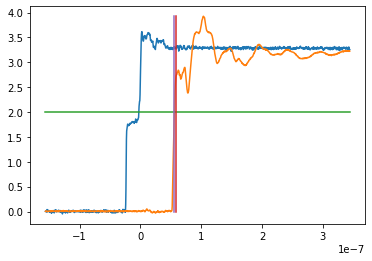

Delay 55.118620197044336 +/- 2.7370273528019715 ns
Min delay 50.360600000000005, Max delay 60.31790000000001, Median 55.161699999999996


In [6]:
# choosing the first time it crosses the threshold or the last time makes a difference in the quantification
def plot_vertical(ref, val, vertical):
    plt.plot(ref[:,0],ref[:,1])
    plt.plot(val[:,0],val[:,1])
    plt.plot([val[0,0], val[-1,0]], [2, 2])
    
    for vert in vertical:
        plt.plot([vert, vert], [0, max(np.max(ref), np.max(val))])
    plt.show()


i_med = np.argmin(abs(delays - np.median(delays)))
print(i_med)
val = all_vals[i_med]

delay0 = np.median(delays) / 1_000_000_000

val1 = val[::-1,:]
delay1 = val1[get_delay_index_inverted(val), 0]

plot_vertical(cam, val, [delay0, delay1])    

# compute delay
delays_inv = get_delays(all_vals, inverted = True)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_inv)} +/- {np.std(delays_inv)} ns')
print(f'Min delay {np.min(delays_inv)}, Max delay {np.max(delays_inv)}, Median {np.median(delays_inv)}')

1 1 1
[61, 116, 189]


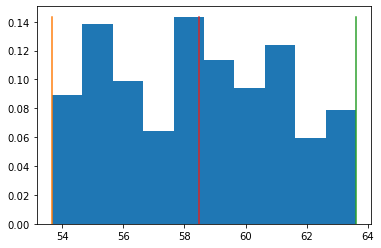

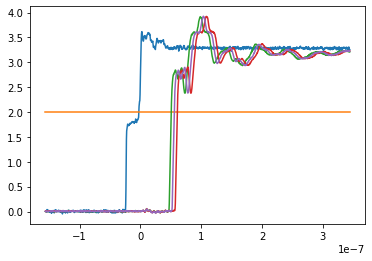

In [7]:
def plot_histo(vals, vertical):
    y, x, _ = plt.hist(vals, density=True)
    
    for v in vertical:
        plt.plot([v, v], [0, max(y)])
    
    plt.show()

# get indices of min, max and median
print(np.sum(delays == np.min(delays)), np.sum(delays == np.max(delays)), np.sum(delays == np.median(delays)))

i_s = [np.argmax(delays == np.min(delays)),
       np.argmax(delays == np.max(delays)),
       np.argmin(abs(delays - np.median(delays)))]
vals = [all_vals[i] for i in i_s]
print(i_s)

plot_histo(delays, delays[i_s]) # check that the median, min and max curves are really so

plot_all(cam, vals)

## Figure 2b: pulse length accuracy

In [8]:
# load data
cam = load_single('3_figure_2b/C1_00000.txt')
ch2 = load_all('3_figure_2b/ch2')
ch3 = load_all('3_figure_2b/ch3')
ch4 = load_all('3_figure_2b/ch4')

In [25]:
print(f'Number of samples: {len(ch2)}')

Number of samples: 205


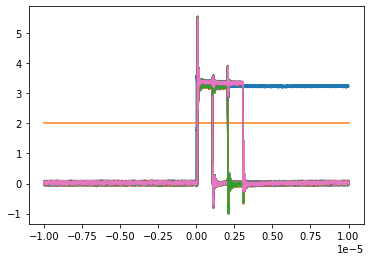

In [18]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4])

In [13]:
# camera threshold
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
print(t0)

-2.4444735e-09


In [15]:
# compute delay
delays_inv = (get_delays(ch2)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_inv)} +/- {np.std(delays_inv)} ns')
print(f'Min delay {np.min(delays_inv)}, Max delay {np.max(delays_inv)}, Median {np.median(delays_inv)}')

# compute delay
delays_inv = (get_delays(ch3)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_inv)} +/- {np.std(delays_inv)} ns')
print(f'Min delay {np.min(delays_inv)}, Max delay {np.max(delays_inv)}, Median {np.median(delays_inv)}')

# compute delay
delays_inv = (get_delays(ch4)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_inv)} +/- {np.std(delays_inv)} ns')
print(f'Min delay {np.min(delays_inv)}, Max delay {np.max(delays_inv)}, Median {np.median(delays_inv)}')

Delay 69.68150746097562 +/- 2.907527658661275 ns
Min delay 64.6484715, Max delay 74.9000415, Median 69.63839150000001
Delay 71.9575978277027 +/- 2.858613542793941 ns
Min delay 66.77733950000001, Max delay 77.0189755, Median 72.0997645
Delay 63.73766096078432 +/- 2.8669026366426578 ns
Min delay 58.917063500000005, Max delay 68.7698025, Median 63.8191815


In [27]:
# compute average delay
def get_pulse_length(laser):

    t0 = []
    t1 = []
    for v in laser:
        for i in range(len(v)-1):
            if v[i,1] <= 2 < v[i+1,1]:
                    t0.append(v[i, 0])

            if v[i,1] >= 2 > v[i+1,1]:
                    t1.append(v[i, 0])
        
        assert len(t0) == len(t1)
        
    pulses = np.array([t1[i]-t0[i] for i in range(len(t1))])*1_000_000
        
    return pulses

t_ch2 = get_pulse_length(ch2)
t_ch3 = get_pulse_length(ch3)
t_ch4 = get_pulse_length(ch4)

print(f'Pulse ch1 {np.mean(t_ch2)} +/- {np.std(t_ch2)} us')
print(f'Pulse ch1 {np.mean(t_ch3)} +/- {np.std(t_ch3)} us')
print(f'Pulse ch1 {np.mean(t_ch4)} +/- {np.std(t_ch4)} us')

Pulse ch1 0.9983434172585367 +/- 0.00017423875432150858 us
Pulse ch1 1.9960810800641893 +/- 0.00019149022888805776 us
Pulse ch1 2.998850978715686 +/- 0.00019938275033233154 us


## Figure 2c: illustrate sequence

In [61]:
# load data
cam = load_single('2_figure_2c/1sec/C1_00000.txt')
ch2 = load_single('2_figure_2c/1sec/C2_00000.txt')
ch3 = load_single('2_figure_2c/1sec/C3_00000.txt')
ch4 = load_single('2_figure_2c/1sec/C4_00000.txt')

In [62]:
def count_frames(ref):
    
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            
    return counter

def find_rising(ref, n = 1):
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] <= 2 < ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1

def find_falling(ref, n = 1):
    counter = 0
    for i in range(len(ref)-1):
        if ref[i,1] >= 2 > ref[i+1,1]:
            counter += 1
            if counter == n:
                return i 
        
    return -1


In [63]:
n_frames = count_frames(cam)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 69
Number of full sequences: 4


In [64]:
i_fr = find_rising(cam)
i_sr = find_rising(cam, 2)
i_ff = find_falling(cam)

offset = int( (i_ff-i_fr) / 2.) 
length_frame = i_sr-i_fr
print(offset, length_frame)

500 1492


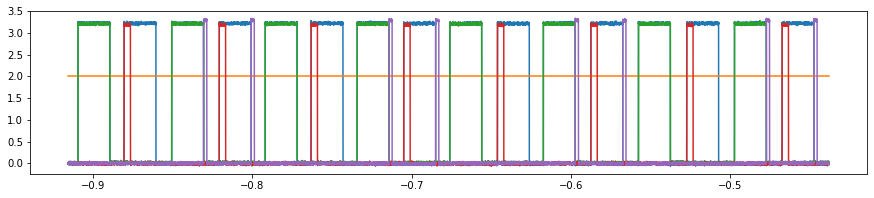

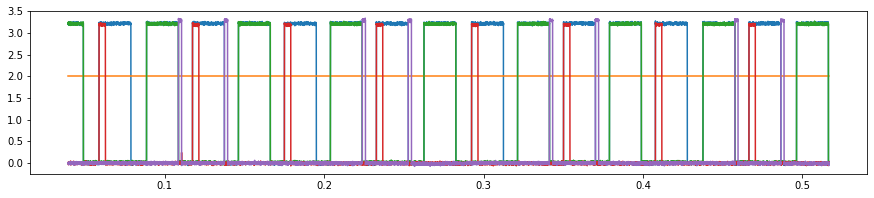

In [65]:
first_pt = 3*length_frame-int(offset/2)
last_pt = first_pt + 16*length_frame
plot_wide(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

first_pt = first_pt + 2*16*length_frame
last_pt = first_pt + 16*length_frame
plot_wide(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

In [66]:
def plot_wide_offset(ref, v_list, factor = 1):
    plt.figure(figsize=(15, 12))
    
    counter = len(v_list)
    fac = 3.5
    plt.plot(ref[:,0],counter*fac+ref[:,1])
    plt.plot([ref[0,0], ref[-1,0]], [counter*fac+2, counter*fac+2])
    for v in v_list:
        counter -= 1
        plt.plot([ref[0,0], ref[-1,0]], [counter*fac+2, counter*fac+2])
        plt.plot(v[:,0],counter*fac+factor*v[:,1])
    plt.show()

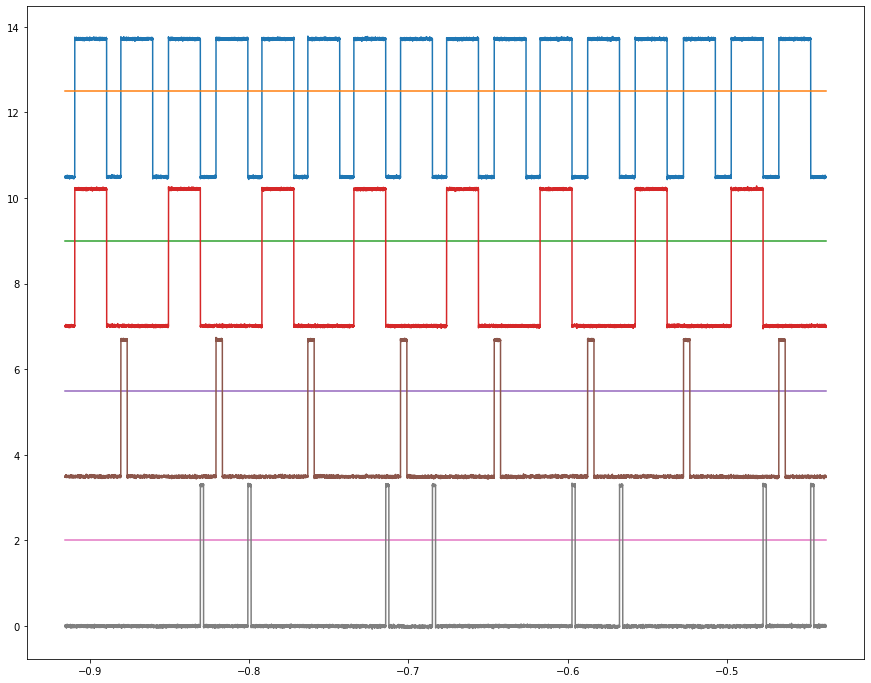

In [67]:
first_pt = 3*length_frame-int(offset/2)
last_pt = first_pt + 16*length_frame
plot_wide_offset(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

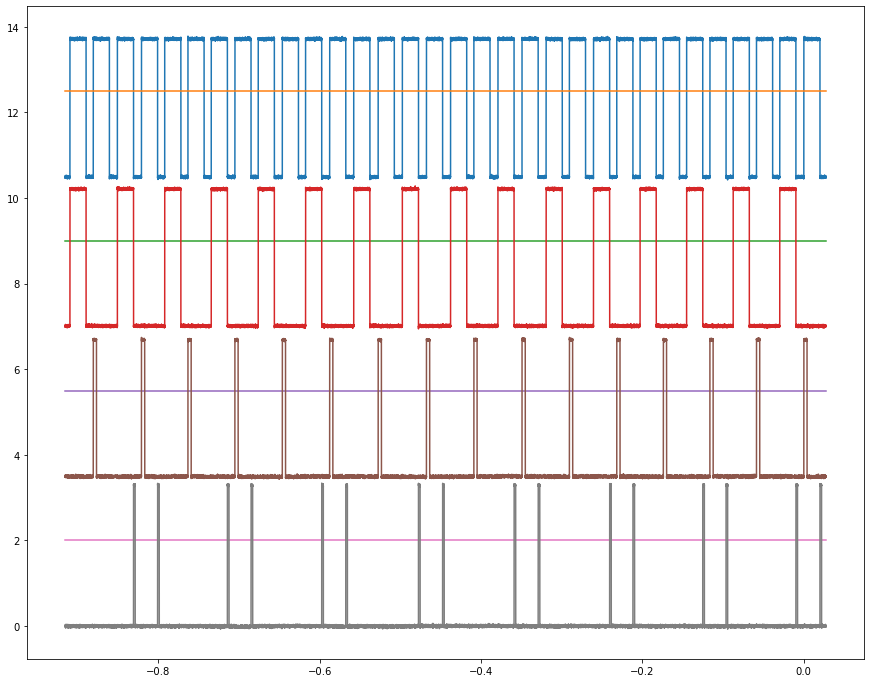

In [68]:
first_pt = 3*length_frame-int(offset/2)
last_pt = first_pt + 2*16*length_frame-int(offset*1.2)
plot_wide_offset(cam[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

## Figure active trigger: illustrate the different parameters

In [69]:
# load data
ch1 = load_single('2_figure_active_trigger/1sec/C1_00000.txt')
ch2 = load_single('2_figure_active_trigger/1sec/C2_00000.txt')
ch3 = load_single('2_figure_active_trigger/1sec/C3_00000.txt')
ch4 = load_single('2_figure_active_trigger/1sec/C4_00000.txt')

In [70]:
n_frames = count_frames(ch1)
print(f'Total number of frames: {n_frames}')
print(f'Number of full sequences: {int(n_frames / 16)}')

Total number of frames: 81
Number of full sequences: 5


In [71]:
i_fr = find_rising(ch2)
i_sr = find_rising(ch2, 2)
i_ff = find_falling(ch2)

offset = int( (i_ff-i_fr) / 2.) 
length_frame = i_sr-i_fr

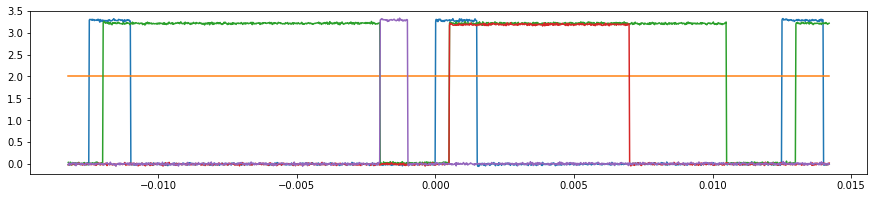

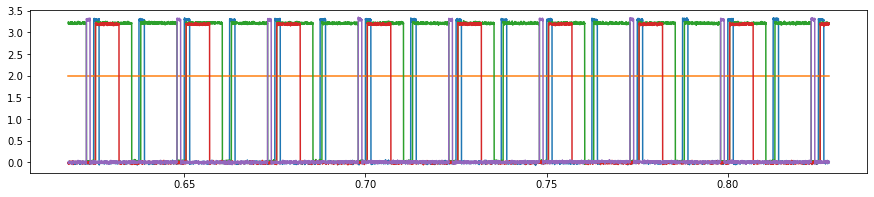

In [72]:
first_pt = i_fr-int(offset/4)
last_pt = i_sr+length_frame+int(offset/4)
plot_wide(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

first_pt = i_ff+4*offset+3*16*length_frame
last_pt = first_pt + 16*length_frame +2*offset
plot_wide(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

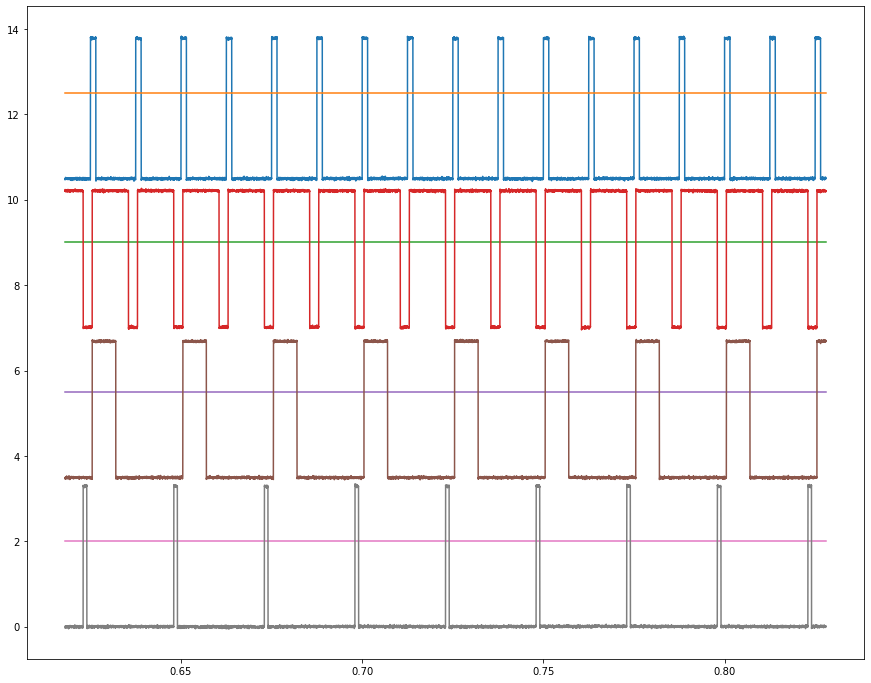

In [73]:
plot_wide_offset(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

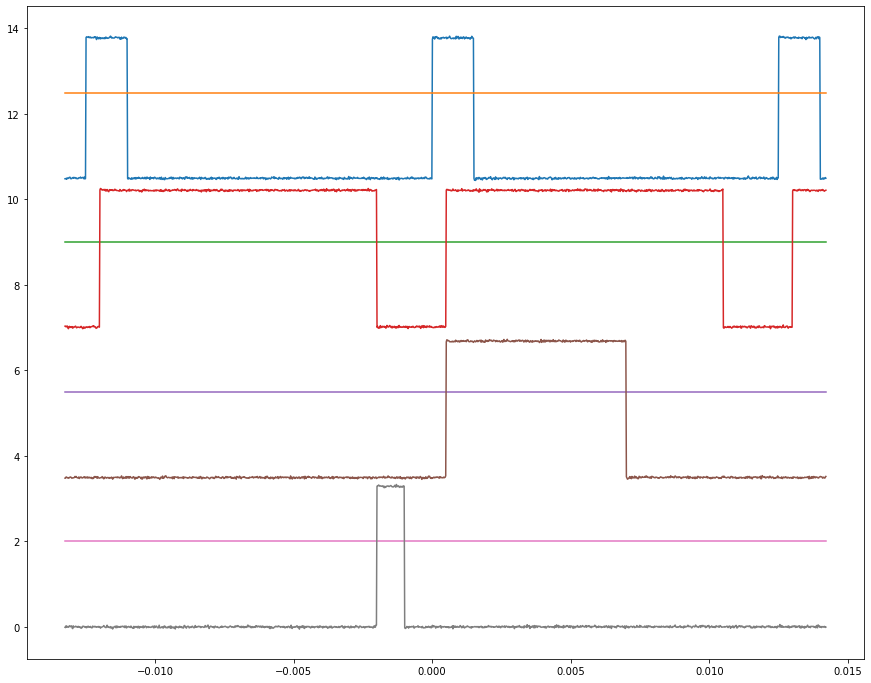

In [74]:
first_pt = i_fr-int(offset/4)
last_pt = i_sr+length_frame+int(offset/4)
plot_wide_offset(ch1[first_pt:last_pt,:], 
          [ch2[first_pt:last_pt,:], 
           ch3[first_pt:last_pt,:], 
           ch4[first_pt:last_pt,:]])

In [75]:
# compute average delay
def get_camera_delay(camera, laser):

    t0 = []
    t1 = []
    t0_f = []
    t1_f = []
    for i in range(len(camera)-1):
        if camera[i,1] <= 2 < camera[i+1,1]:
                t0.append(camera[i, 0])
        
        if laser[i,1] <= 2 < laser[i+1,1]:
                t1.append(laser[i, 0])
                
        if camera[i,1] >= 2 > camera[i+1,1]:
                t0_f.append(laser[i, 0])
                
        if laser[i,1] >= 2 > laser[i+1,1]:
                t1_f.append(laser[i, 0])
        
    assert len(t0) == len(t1)
    assert len(t0) == len(t0_f)
    assert len(t1) == len(t1_f)
        
    delays = np.array([t1[i]-t0[i] for i in range(len(t1))])*1_000_000
    expo = np.array([t1_f[i]-t1[i] for i in range(len(t1))])*1_000_000
    pulse = np.array([t0_f[i]-t0[i] for i in range(len(t0))])*1_000_000
    period = np.array([t0[i+1]-t0[i] for i in range(len(t0)-1)])*1_000_000
        
    return delays, expo, pulse, period

t_delays, t_expo, t_pulse, t_period = get_camera_delay(ch1, ch2)

print(f'Delay {np.mean(t_delays)} +/- {np.std(t_delays)} us')
print(f'Exposure {np.mean(t_expo)} +/- {np.std(t_expo)} us')
print(f'Pulse {np.mean(t_pulse)} +/- {np.std(t_pulse)} us')
print(f'Period {np.mean(t_period)} +/- {np.std(t_period)} us')

Delay 500.9898427160442 +/- 0.0005275590454737317 us
Exposure 9999.999999506177 +/- 6.606957123801298e-05 us
Pulse 1500.9898422222175 +/- 0.0005281226922045332 us
Period 12499.999950000003 +/- 0.00044532010972909617 us


## Figure active a: measure delay in pulsing

In [76]:
# load data
cam = load_single('2_figure_active_a/C1_00000.txt')
all_vals = load_all('2_figure_active_a/ch2')
print(f'Number of measurements: {len(all_vals)}')

Number of measurements: 232


In [77]:
# cam threshold
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
print(t0)

-1.210547e-10


In [78]:
# compute delay
delays = (get_delays(all_vals)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Max delay {np.max(delays)}, Median {np.median(delays)}')

Delay 54.32191047586206 +/- 0.16923160082923502 ns
Min delay 53.944734700000005, Max delay 54.718144699999996, Median 54.3122997


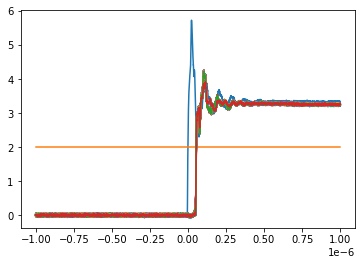

In [79]:
plot_all(cam, all_vals)

## Figure active b: measure pulse widths

In [36]:
# load data
cam = load_single('3_figure_active_b/C1_00000.txt')
ch2 = load_all('3_figure_active_b/ch2')
ch3 = load_all('3_figure_active_b/ch3')
ch4 = load_all('3_figure_active_b/ch4')

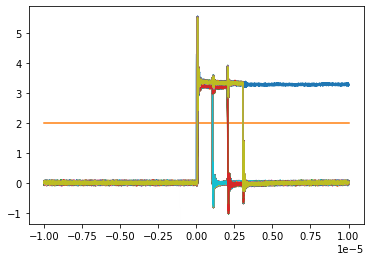

In [37]:
# show data
plot_multichannel(cam, [ch2, ch3, ch4])

In [38]:
# cam threshold
t0 = cam[np.argmax(cam[:,1] >= 2), 0]
print(t0)

-1.5997694e-09


In [40]:
# compute delay
delays_ch2 = (get_delays(ch2)-t0)*1_000_000_000  # to ns
delays_ch3 = (get_delays(ch3)-t0)*1_000_000_000  # to ns
delays_ch4 = (get_delays(ch4)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays_ch2)} +/- {np.std(delays_ch2)} ns')
print(f'Min delay {np.min(delays_ch2)}, Max delay {np.max(delays_ch2)}, Median {np.median(delays_ch2)}')

print(f'Delay {np.mean(delays_ch3)} +/- {np.std(delays_ch3)} ns')
print(f'Min delay {np.min(delays_ch3)}, Max delay {np.max(delays_ch3)}, Median {np.median(delays_ch3)}')

print(f'Delay {np.mean(delays_ch4)} +/- {np.std(delays_ch4)} ns')
print(f'Min delay {np.min(delays_ch4)}, Max delay {np.max(delays_ch4)}, Median {np.median(delays_ch4)}')

Delay 66.08559570288462 +/- 0.13796233013559142 ns
Min delay 65.70559340000001, Max delay 66.4933214, Median 66.08835440000001
Delay 68.15750633627451 +/- 0.13894600448446512 ns
Min delay 67.8324154, Max delay 68.54096240000001, Median 68.1544024
Delay 60.28937799024391 +/- 0.13826782376140595 ns
Min delay 59.997560400000005, Max delay 60.66023340000001, Median 60.2906204


In [41]:
print(f'Number of samples: {len(ch2)}')

Number of samples: 208


In [42]:
t_ch2 = get_pulse_length(ch2)
t_ch3 = get_pulse_length(ch3)
t_ch4 = get_pulse_length(ch4)

print(f'Pulse ch1 {np.mean(t_ch2)} +/- {np.std(t_ch2)} us')
print(f'Pulse ch1 {np.mean(t_ch3)} +/- {np.std(t_ch3)} us')
print(f'Pulse ch1 {np.mean(t_ch4)} +/- {np.std(t_ch4)} us')

Pulse ch1 0.9983615395625001 +/- 0.00014696031447762126 us
Pulse ch1 1.9962490204166667 +/- 0.0001939006856585576 us
Pulse ch1 2.9987746353121953 +/- 0.0001315598621250581 us
